# Importing packages

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Installing UGent Panno font

Before running there are a few steps that need to be taken.

Download this: https://www.ugent.be/intranet/nl/op-het-werk/communicatie/huisstijl-presentaties/huisstijl/panno-text.zip
Unzip 'panno-text.zip'

Open and unzip '150831-ugentpannotext-v300-truetype.zip'

Upload the 'UGentPannoText-Normal' to this drive in the local directory!!!! (on the left bar, click the folder-icon, upload the 'UGentPannoText-Normal')

In [ ]:
font_files = fm.findSystemFonts('.')

for font_file in font_files:
    fm.fontManager.addfont(font_file)
print(font_files)
plt.rc('font', family='UGent Panno Text')

['/content/UGentPannoText-SemiBold.ttf', '/content/UGentPannoText-Medium.ttf', '/content/UGentPannoText-Normal.ttf', '/content/UGentPannoText-SemiLight.ttf']


# Defining plot layout

In [ ]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Model definition

In [ ]:
def FCNK(kmer, tax, epochsize):
    print(f'Initiating training, validation and testing on {tax} level with {kmer}.')

    class mydataset(Dataset):
        def __init__(self, x, y):
            self.x = torch.tensor(x, dtype=torch.float32, device='cpu')
            self.y = torch.tensor(y, dtype=torch.long, device='cpu')
            self.length = self.x.shape[0]

        def __getitem__(self, idx):
            return self.x[idx], self.y[idx]

        def __len__(self):
            return self.length

    class Net(nn.Module):
        def __init__(self, input_shape, output_shape, shape1, shape2):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(input_shape, shape1)
            self.fc2 = nn.Linear(shape1, shape2)
            self.fcout = nn.Linear(shape2, output_shape)
            self.relu = nn.ReLU()

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)

            out = self.fc2(out)
            out = self.relu(out)

            out = self.fcout(out)
            return out

    # Load the existed Training & Validation & Testing Dataset
    base_path = '/content/drive/MyDrive/BachelorsProject/FinalModels/5NOAMBI/'
    
    # These files are all in my google drive
    TrainX = np.load(f'{base_path}Train_X_{kmer}5NA.npy')
    TrainY = np.load(f'{base_path}Train_Y_{tax}5NA.npy')
    TestX = np.load(f'{base_path}Test_X_{kmer}5NA.npy')
    TestY = np.load(f'{base_path}Test_Y_{tax}5NA.npy')
    ValX = np.load(f'{base_path}Validation_X_{kmer}5NA.npy')
    ValY = np.load(f'{base_path}Validation_Y_{tax}5NA.npy')
    print('Training, test and validation datasets are loaded...')

    batches = 100
    trainset = mydataset(TrainX, TrainY)
    valset = mydataset(ValX, ValY)
    testset = mydataset(TestX, TestY)
    trainloader = DataLoader(trainset, batch_size=batches, shuffle=True)
    valloader = DataLoader(valset, batch_size=batches, shuffle=False)
    testloader = DataLoader(testset, batch_size=batches, shuffle=False)
    print('Loading trainset, trainloader, testset, testloader ...')

    learning_rate = 0.001
    epochs = epochsize
    input_size = TrainX.shape[1]
    size1 = TrainX.shape[1] * 3 // 4
    size2 = TrainX.shape[1] * 1 // 4
    output_size = len(np.unique(TrainY))
    model = Net(input_shape=input_size, output_shape=output_size, shape1= size1, shape2= size2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    print('Setting hyperparameters...')

    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    print('Training model...')
    for epoch in range(epochs):
        # Training loop
        model.train()
        training_loss = 0.0
        correct = 0
        total = 0
        for j, (x_train, y_train) in enumerate(trainloader):
            # calculate output
            output = model(x_train)

            # calculate loss
            loss = loss_fn(output, y_train)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss and accuracy
            training_loss += loss.item() * x_train.size(0)
            output_tags = torch.argmax(output, dim=1)
            targets = y_train
            correct += (output_tags == targets).sum().item()
            total += y_train.size(0)

        # Print training statistics
        epoch_loss = training_loss / len(trainloader.dataset)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch + 1}] Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')

        # Store the training loss and training accuracy
        training_losses.append(epoch_loss)
        training_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for j, (x_val, y_val) in enumerate(valloader):
                output = model(x_val)
                loss = loss_fn(output, y_val)
                # Calculate validation loss and accuracy
                validation_loss += loss.item() * x_val.size(0)
                output_tags = torch.argmax(output, dim=1)
                targets = y_val
                correct += (output_tags == targets).sum().item()
                total += y_val.size(0)

        # Print validation statistics
        epoch_val_loss = validation_loss / len(valloader.dataset)
        epoch_val_acc = 100. * correct / total
        print(f'Epoch [{epoch + 1}] Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%')

        # Store the validation loss and validation accuracy
        validation_losses.append(epoch_val_loss)
        validation_accuracies.append(epoch_val_acc)

    # Testing
    with torch.no_grad():
        y_pred = []
        y_true = []
        # simple accuracy as above
        for x_test, y_test in testloader:
            test_output = model(x_test)
            y_pred += torch.argmax(test_output, dim=1).tolist()
            y_true += y_test.tolist()
        report_dict = metrics.classification_report(y_true, y_pred, digits=3)
        print(report_dict)


    plt.plot(training_losses, label='Training', color='#1E64C8', linewidth=1)
    plt.plot(validation_losses, label='Validation', color='black', linewidth=1)
    plt.title(f'Training and Validation Loss of the FCN on {tax} level with {kmer}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (in %)')
    plt.legend()
    plt.savefig(f'FCNK{tax}{kmer}Loss5NA.svg')
    files.download(f'FCNK{tax}{kmer}Loss5NA.svg') 
    plt.show()

    plt.plot(training_accuracies, label='Training', color='#1E64C8', linewidth=1)
    plt.plot(validation_accuracies, label='Validation', color='black', linewidth=1)
    plt.title(f'Training and Validation Accuracy of the FCN on {tax} level with {kmer}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (in %)')
    plt.legend()
    plt.savefig(f'FCNK{tax}{kmer}Accuracy5NA.svg')
    files.download(f'FCNK{tax}{kmer}Accuracy5NA.svg') 
    plt.show()
    print(f'Training, validation and testing on {tax} level with {kmer} is completed.')

# 3mer

Initiating training, validation and testing on PHYLUM level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.0097, Training Accuracy: 67.34%
Epoch [1] Validation Loss: 0.7978, Validation Accuracy: 71.68%
Epoch [2] Training Loss: 0.6827, Training Accuracy: 74.90%
Epoch [2] Validation Loss: 0.4616, Validation Accuracy: 88.90%
Epoch [3] Training Loss: 0.3758, Training Accuracy: 89.25%
Epoch [3] Validation Loss: 0.2941, Validation Accuracy: 90.24%
Epoch [4] Training Loss: 0.2422, Training Accuracy: 91.63%
Epoch [4] Validation Loss: 0.1726, Validation Accuracy: 94.63%
Epoch [5] Training Loss: 0.1531, Training Accuracy: 95.01%
Epoch [5] Validation Loss: 0.1335, Validation Accuracy: 95.45%
Epoch [6] Training Loss: 0.1212, Training Accuracy: 95.91%
Epoch [6] Validation Loss: 0.1080, Validation Accuracy: 96.45%
Epoch [7] Training Loss: 0.1044, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

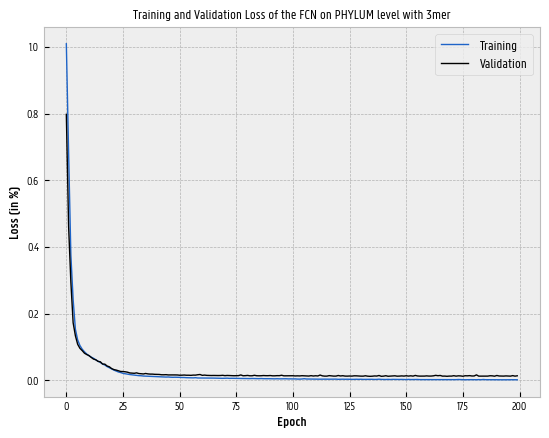

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

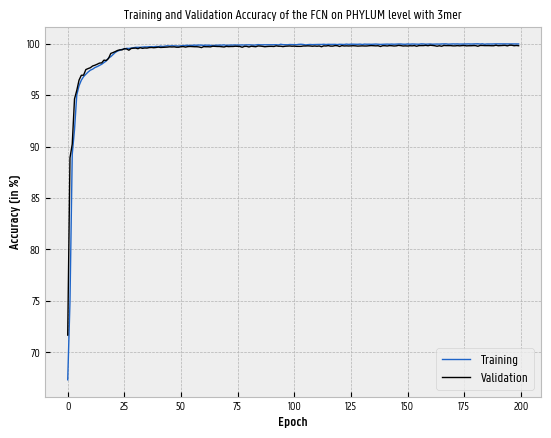

Training, validation and testing on PHYLUM level with 3mer is completed.


In [ ]:
FCNK('3mer', 'PHYLUM', 200)

Initiating training, validation and testing on CLASS level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.3306, Training Accuracy: 62.06%
Epoch [1] Validation Loss: 1.0050, Validation Accuracy: 71.68%
Epoch [2] Training Loss: 0.9945, Training Accuracy: 70.44%
Epoch [2] Validation Loss: 0.9057, Validation Accuracy: 71.68%
Epoch [3] Training Loss: 0.8067, Training Accuracy: 72.36%
Epoch [3] Validation Loss: 0.6298, Validation Accuracy: 83.59%
Epoch [4] Training Loss: 0.5374, Training Accuracy: 83.94%
Epoch [4] Validation Loss: 0.4438, Validation Accuracy: 84.72%
Epoch [5] Training Loss: 0.4065, Training Accuracy: 86.23%
Epoch [5] Validation Loss: 0.3395, Validation Accuracy: 88.90%
Epoch [6] Training Loss: 0.3015, Training Accuracy: 89.49%
Epoch [6] Validation Loss: 0.2538, Validation Accuracy: 91.41%
Epoch [7] Training Loss: 0.2313, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

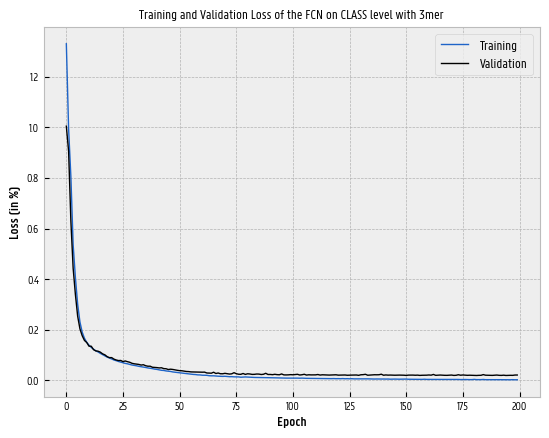

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

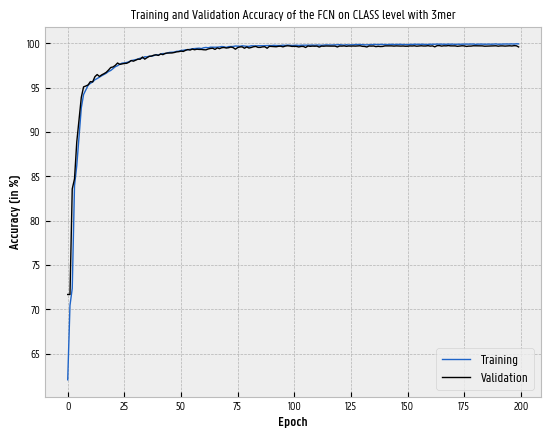

Training, validation and testing on CLASS level with 3mer is completed.


In [ ]:
FCNK('3mer', 'CLASS', 200)

Initiating training, validation and testing on ORDER level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 2.3569, Training Accuracy: 29.91%
Epoch [1] Validation Loss: 2.1653, Validation Accuracy: 30.53%
Epoch [2] Training Loss: 1.9506, Training Accuracy: 35.51%
Epoch [2] Validation Loss: 1.6555, Validation Accuracy: 49.52%
Epoch [3] Training Loss: 1.4602, Training Accuracy: 57.38%
Epoch [3] Validation Loss: 1.1862, Validation Accuracy: 68.12%
Epoch [4] Training Loss: 1.0126, Training Accuracy: 70.95%
Epoch [4] Validation Loss: 0.8479, Validation Accuracy: 76.11%
Epoch [5] Training Loss: 0.7901, Training Accuracy: 76.86%
Epoch [5] Validation Loss: 0.7095, Validation Accuracy: 79.23%
Epoch [6] Training Loss: 0.6923, Training Accuracy: 78.82%
Epoch [6] Validation Loss: 0.6446, Validation Accuracy: 81.05%
Epoch [7] Training Loss: 0.6399, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

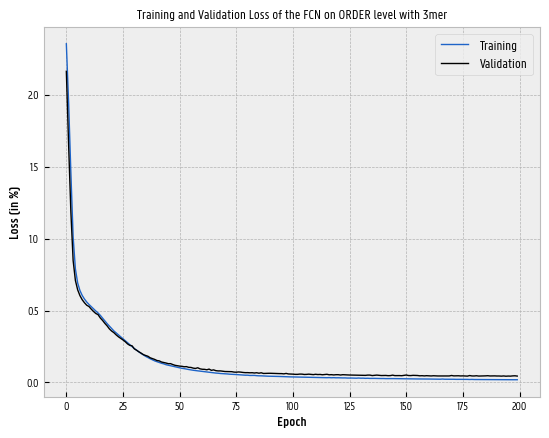

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

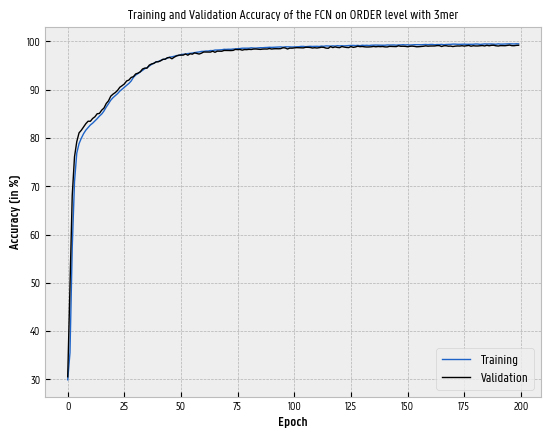

Training, validation and testing on ORDER level with 3mer is completed.


In [ ]:
FCNK('3mer', 'ORDER', 200)

Initiating training, validation and testing on FAMILY level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.0800, Training Accuracy: 13.56%
Epoch [1] Validation Loss: 2.8891, Validation Accuracy: 16.44%
Epoch [2] Training Loss: 2.6091, Training Accuracy: 24.15%
Epoch [2] Validation Loss: 2.2524, Validation Accuracy: 32.23%
Epoch [3] Training Loss: 1.9092, Training Accuracy: 46.00%
Epoch [3] Validation Loss: 1.5583, Validation Accuracy: 53.83%
Epoch [4] Training Loss: 1.4370, Training Accuracy: 56.03%
Epoch [4] Validation Loss: 1.3062, Validation Accuracy: 57.32%
Epoch [5] Training Loss: 1.2575, Training Accuracy: 59.72%
Epoch [5] Validation Loss: 1.1726, Validation Accuracy: 63.18%
Epoch [6] Training Loss: 1.1450, Training Accuracy: 62.56%
Epoch [6] Validation Loss: 1.0738, Validation Accuracy: 64.72%
Epoch [7] Training Loss: 1.0524, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

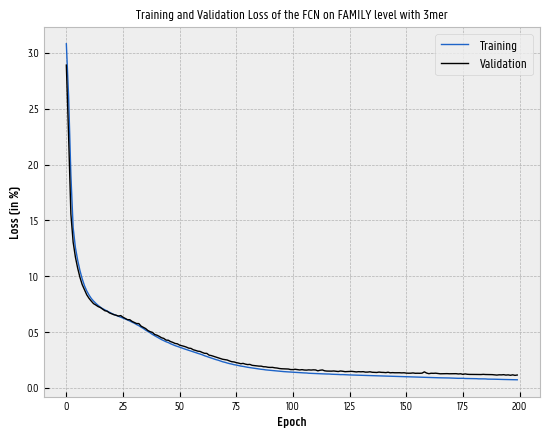

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

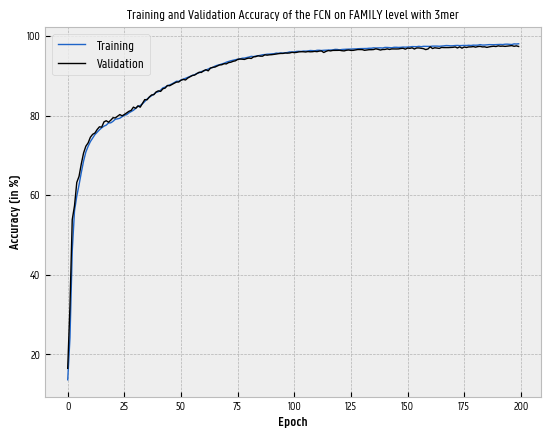

Training, validation and testing on FAMILY level with 3mer is completed.


In [ ]:
FCNK('3mer', 'FAMILY', 200)

Initiating training, validation and testing on GENUS level with 3mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.3391, Training Accuracy: 14.16%
Epoch [1] Validation Loss: 3.1934, Validation Accuracy: 16.44%
Epoch [2] Training Loss: 3.0940, Training Accuracy: 15.64%
Epoch [2] Validation Loss: 2.8040, Validation Accuracy: 19.75%
Epoch [3] Training Loss: 2.4663, Training Accuracy: 35.14%
Epoch [3] Validation Loss: 2.0496, Validation Accuracy: 46.63%
Epoch [4] Training Loss: 1.8347, Training Accuracy: 49.27%
Epoch [4] Validation Loss: 1.6476, Validation Accuracy: 51.59%
Epoch [5] Training Loss: 1.5945, Training Accuracy: 51.94%
Epoch [5] Validation Loss: 1.5123, Validation Accuracy: 53.51%
Epoch [6] Training Loss: 1.4969, Training Accuracy: 53.32%
Epoch [6] Validation Loss: 1.4436, Validation Accuracy: 55.29%
Epoch [7] Training Loss: 1.4408, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

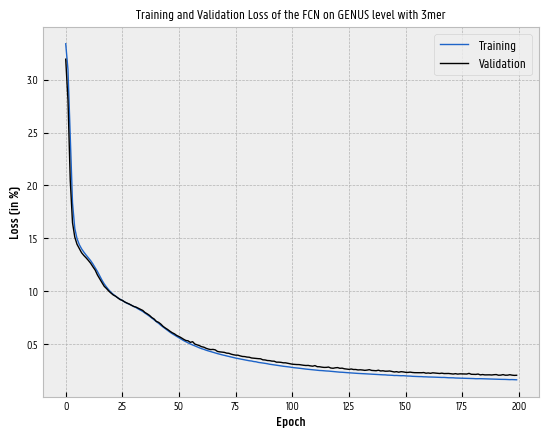

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

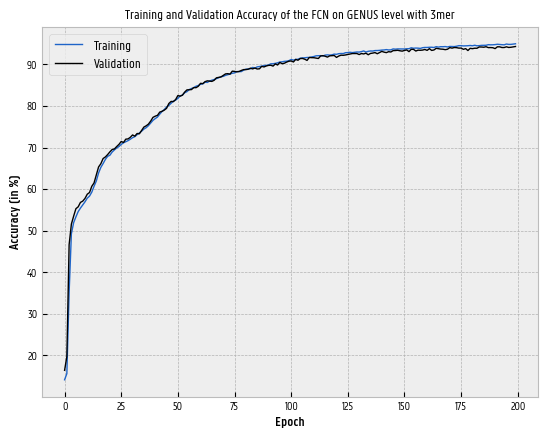

Training, validation and testing on GENUS level with 3mer is completed.


In [ ]:
FCNK('3mer', 'GENUS', 200)

# 4mer

Initiating training, validation and testing on PHYLUM level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.7386, Training Accuracy: 73.31%
Epoch [1] Validation Loss: 0.2453, Validation Accuracy: 90.68%
Epoch [2] Training Loss: 0.1262, Training Accuracy: 95.52%
Epoch [2] Validation Loss: 0.0551, Validation Accuracy: 98.56%
Epoch [3] Training Loss: 0.0371, Training Accuracy: 98.85%
Epoch [3] Validation Loss: 0.0244, Validation Accuracy: 99.08%
Epoch [4] Training Loss: 0.0151, Training Accuracy: 99.74%
Epoch [4] Validation Loss: 0.0130, Validation Accuracy: 99.81%
Epoch [5] Training Loss: 0.0075, Training Accuracy: 99.92%
Epoch [5] Validation Loss: 0.0103, Validation Accuracy: 99.84%
Epoch [6] Training Loss: 0.0048, Training Accuracy: 99.93%
Epoch [6] Validation Loss: 0.0113, Validation Accuracy: 99.84%
Epoch [7] Training Loss: 0.0034, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

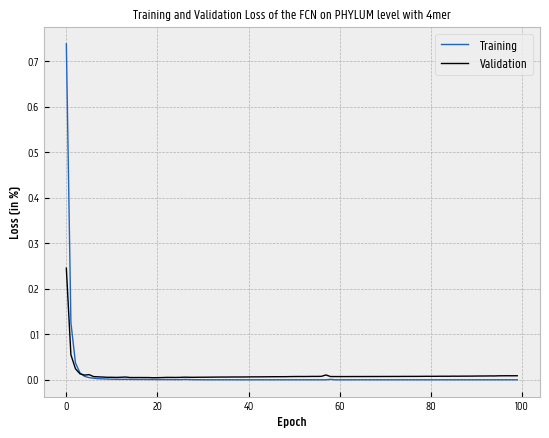

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

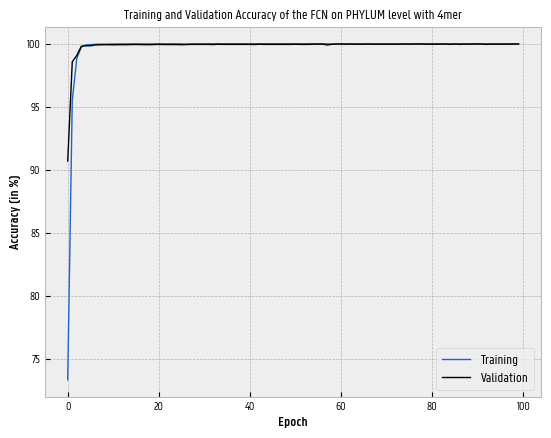

Training, validation and testing on PHYLUM level with 4mer is completed.


In [ ]:
FCNK('4mer', 'PHYLUM', 100)

Initiating training, validation and testing on CLASS level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.9469, Training Accuracy: 73.24%
Epoch [1] Validation Loss: 0.4656, Validation Accuracy: 84.92%
Epoch [2] Training Loss: 0.3041, Training Accuracy: 89.62%
Epoch [2] Validation Loss: 0.1365, Validation Accuracy: 96.28%
Epoch [3] Training Loss: 0.0856, Training Accuracy: 97.37%
Epoch [3] Validation Loss: 0.0611, Validation Accuracy: 98.00%
Epoch [4] Training Loss: 0.0472, Training Accuracy: 98.57%
Epoch [4] Validation Loss: 0.0435, Validation Accuracy: 99.23%
Epoch [5] Training Loss: 0.0330, Training Accuracy: 99.28%
Epoch [5] Validation Loss: 0.0362, Validation Accuracy: 99.34%
Epoch [6] Training Loss: 0.0244, Training Accuracy: 99.57%
Epoch [6] Validation Loss: 0.0280, Validation Accuracy: 99.54%
Epoch [7] Training Loss: 0.0176, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

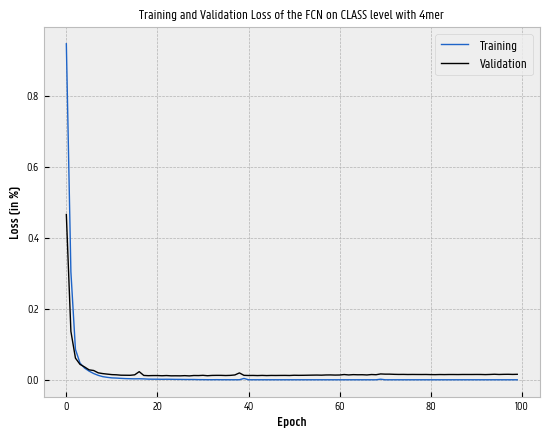

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

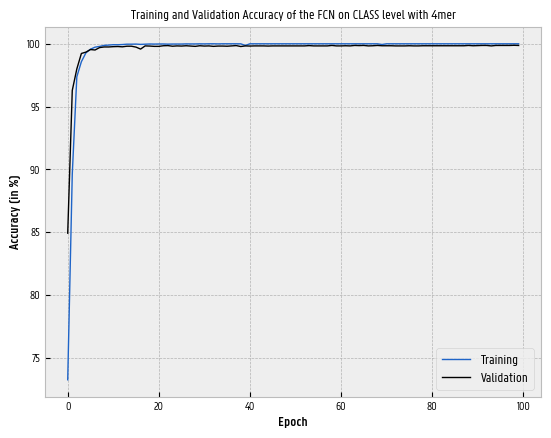

Training, validation and testing on CLASS level with 4mer is completed.


In [ ]:
FCNK('4mer', 'CLASS', 100)

Initiating training, validation and testing on ORDER level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 2.0433, Training Accuracy: 35.70%
Epoch [1] Validation Loss: 1.2092, Validation Accuracy: 63.86%
Epoch [2] Training Loss: 0.7155, Training Accuracy: 78.06%
Epoch [2] Validation Loss: 0.4357, Validation Accuracy: 86.36%
Epoch [3] Training Loss: 0.3315, Training Accuracy: 90.40%
Epoch [3] Validation Loss: 0.2411, Validation Accuracy: 93.57%
Epoch [4] Training Loss: 0.1934, Training Accuracy: 94.54%
Epoch [4] Validation Loss: 0.1515, Validation Accuracy: 96.52%
Epoch [5] Training Loss: 0.1247, Training Accuracy: 97.23%
Epoch [5] Validation Loss: 0.1060, Validation Accuracy: 97.98%
Epoch [6] Training Loss: 0.0860, Training Accuracy: 98.37%
Epoch [6] Validation Loss: 0.0844, Validation Accuracy: 98.58%
Epoch [7] Training Loss: 0.0648, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

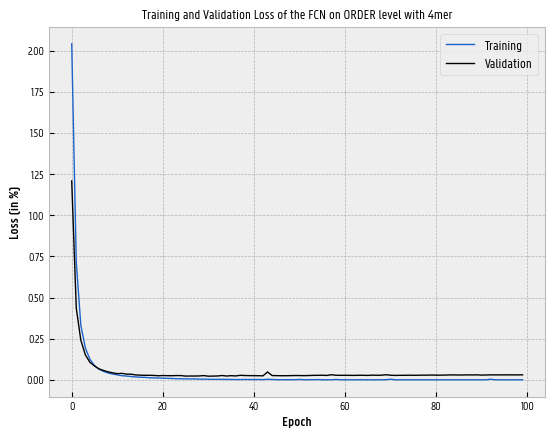

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

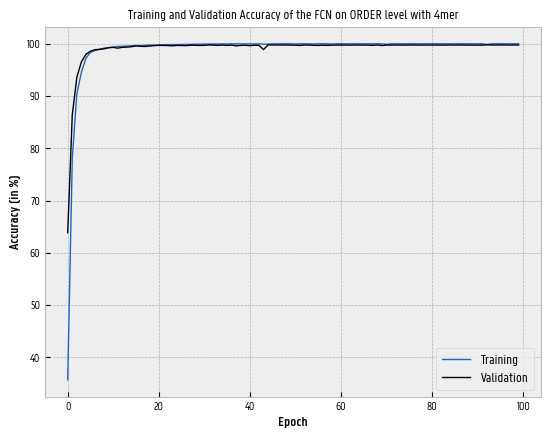

Training, validation and testing on ORDER level with 4mer is completed.


In [ ]:
FCNK('4mer', 'ORDER', 100)

Initiating training, validation and testing on FAMILY level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 2.7910, Training Accuracy: 20.95%
Epoch [1] Validation Loss: 1.9892, Validation Accuracy: 47.63%
Epoch [2] Training Loss: 1.3785, Training Accuracy: 59.28%
Epoch [2] Validation Loss: 0.9516, Validation Accuracy: 69.88%
Epoch [3] Training Loss: 0.7823, Training Accuracy: 76.72%
Epoch [3] Validation Loss: 0.6199, Validation Accuracy: 82.10%
Epoch [4] Training Loss: 0.5510, Training Accuracy: 83.49%
Epoch [4] Validation Loss: 0.4776, Validation Accuracy: 85.94%
Epoch [5] Training Loss: 0.4368, Training Accuracy: 86.92%
Epoch [5] Validation Loss: 0.3875, Validation Accuracy: 89.21%
Epoch [6] Training Loss: 0.3505, Training Accuracy: 89.84%
Epoch [6] Validation Loss: 0.3128, Validation Accuracy: 91.88%
Epoch [7] Training Loss: 0.2788, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

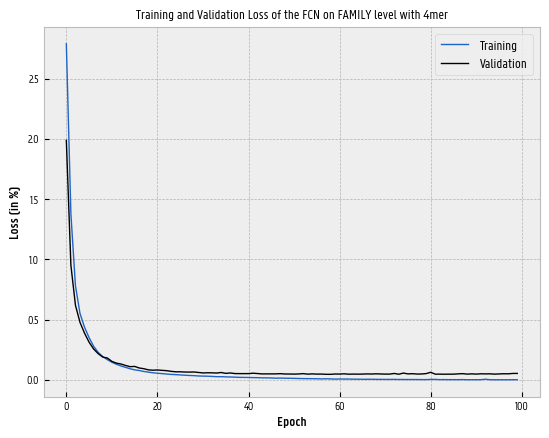

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

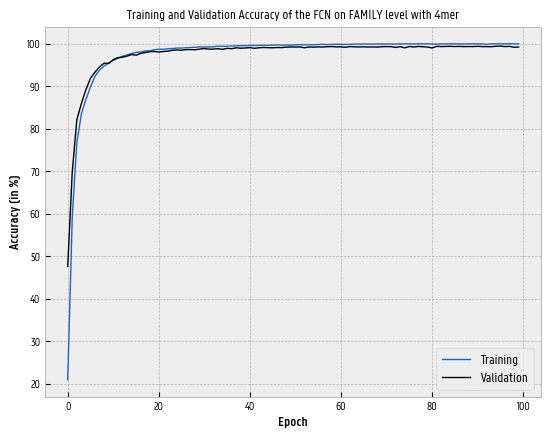

Training, validation and testing on FAMILY level with 4mer is completed.


In [ ]:
FCNK('4mer', 'FAMILY', 100)

Initiating training, validation and testing on GENUS level with 4mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.0756, Training Accuracy: 17.98%
Epoch [1] Validation Loss: 2.3859, Validation Accuracy: 37.36%
Epoch [2] Training Loss: 1.6757, Training Accuracy: 52.22%
Epoch [2] Validation Loss: 1.2649, Validation Accuracy: 60.54%
Epoch [3] Training Loss: 1.1090, Training Accuracy: 65.41%
Epoch [3] Validation Loss: 0.9527, Validation Accuracy: 69.94%
Epoch [4] Training Loss: 0.8559, Training Accuracy: 73.08%
Epoch [4] Validation Loss: 0.7702, Validation Accuracy: 75.49%
Epoch [5] Training Loss: 0.7035, Training Accuracy: 77.22%
Epoch [5] Validation Loss: 0.6551, Validation Accuracy: 79.00%
Epoch [6] Training Loss: 0.6195, Training Accuracy: 79.71%
Epoch [6] Validation Loss: 0.5954, Validation Accuracy: 79.98%
Epoch [7] Training Loss: 0.5575, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

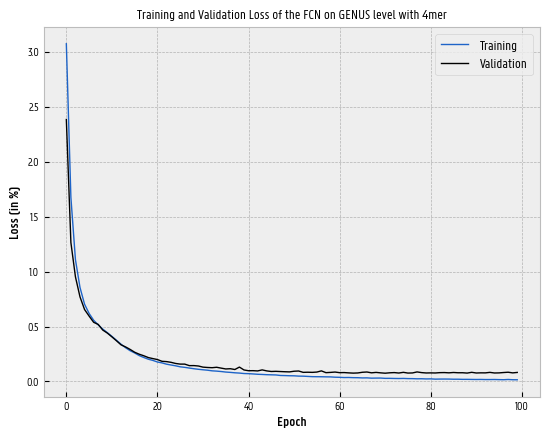

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

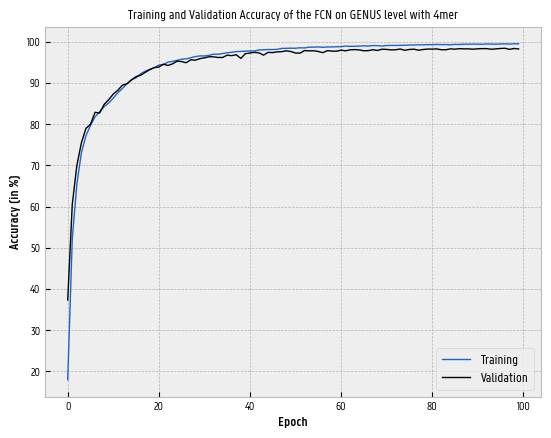

Training, validation and testing on GENUS level with 4mer is completed.


In [ ]:
FCNK('4mer', 'GENUS', 100)

# 5mer

Initiating training, validation and testing on PHYLUM level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.3153, Training Accuracy: 88.27%
Epoch [1] Validation Loss: 0.0138, Validation Accuracy: 99.90%
Epoch [2] Training Loss: 0.0038, Training Accuracy: 99.97%
Epoch [2] Validation Loss: 0.0048, Validation Accuracy: 99.93%
Epoch [3] Training Loss: 0.0014, Training Accuracy: 99.98%
Epoch [3] Validation Loss: 0.0041, Validation Accuracy: 99.94%
Epoch [4] Training Loss: 0.0006, Training Accuracy: 99.99%
Epoch [4] Validation Loss: 0.0040, Validation Accuracy: 99.96%
Epoch [5] Training Loss: 0.0004, Training Accuracy: 99.99%
Epoch [5] Validation Loss: 0.0037, Validation Accuracy: 99.95%
Epoch [6] Training Loss: 0.0001, Training Accuracy: 100.00%
Epoch [6] Validation Loss: 0.0041, Validation Accuracy: 99.96%
Epoch [7] Training Loss: 0.0000, Training A

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

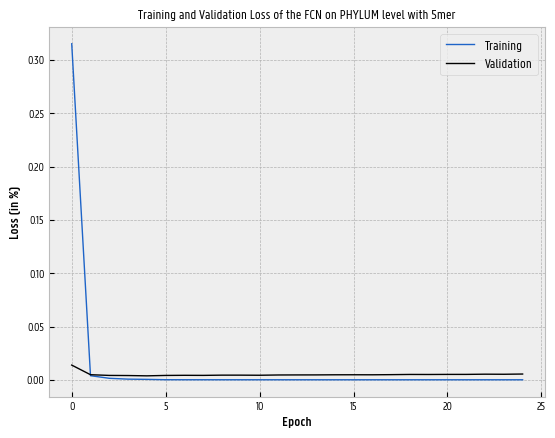

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

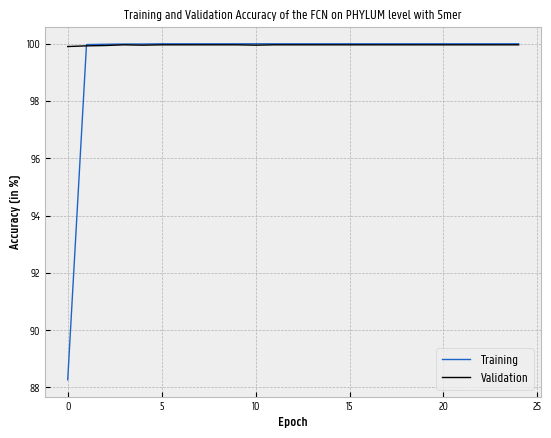

Training, validation and testing on PHYLUM level with 5mer is completed.


In [ ]:
FCNK('5mer', 'PHYLUM', 25)

Initiating training, validation and testing on CLASS level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 0.4898, Training Accuracy: 84.28%
Epoch [1] Validation Loss: 0.0468, Validation Accuracy: 98.53%
Epoch [2] Training Loss: 0.0175, Training Accuracy: 99.75%
Epoch [2] Validation Loss: 0.0130, Validation Accuracy: 99.86%
Epoch [3] Training Loss: 0.0042, Training Accuracy: 99.95%
Epoch [3] Validation Loss: 0.0085, Validation Accuracy: 99.89%
Epoch [4] Training Loss: 0.0019, Training Accuracy: 99.98%
Epoch [4] Validation Loss: 0.0081, Validation Accuracy: 99.90%
Epoch [5] Training Loss: 0.0010, Training Accuracy: 99.99%
Epoch [5] Validation Loss: 0.0074, Validation Accuracy: 99.93%
Epoch [6] Training Loss: 0.0005, Training Accuracy: 99.99%
Epoch [6] Validation Loss: 0.0079, Validation Accuracy: 99.94%
Epoch [7] Training Loss: 0.0001, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

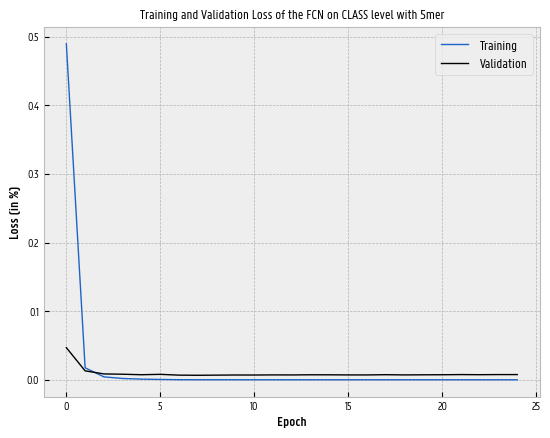

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

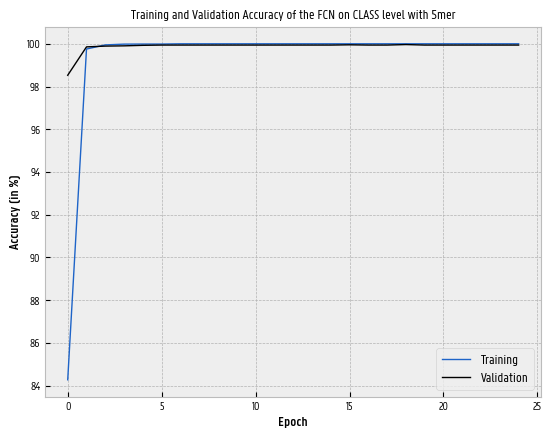

Training, validation and testing on CLASS level with 5mer is completed.


In [ ]:
FCNK('5mer', 'CLASS', 25)

Initiating training, validation and testing on ORDER level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.1318, Training Accuracy: 64.30%
Epoch [1] Validation Loss: 0.1383, Validation Accuracy: 97.20%
Epoch [2] Training Loss: 0.0524, Training Accuracy: 99.14%
Epoch [2] Validation Loss: 0.0307, Validation Accuracy: 99.59%
Epoch [3] Training Loss: 0.0151, Training Accuracy: 99.75%
Epoch [3] Validation Loss: 0.0184, Validation Accuracy: 99.78%
Epoch [4] Training Loss: 0.0076, Training Accuracy: 99.90%
Epoch [4] Validation Loss: 0.0173, Validation Accuracy: 99.83%
Epoch [5] Training Loss: 0.0043, Training Accuracy: 99.95%
Epoch [5] Validation Loss: 0.0166, Validation Accuracy: 99.79%
Epoch [6] Training Loss: 0.0024, Training Accuracy: 99.98%
Epoch [6] Validation Loss: 0.0144, Validation Accuracy: 99.83%
Epoch [7] Training Loss: 0.0014, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

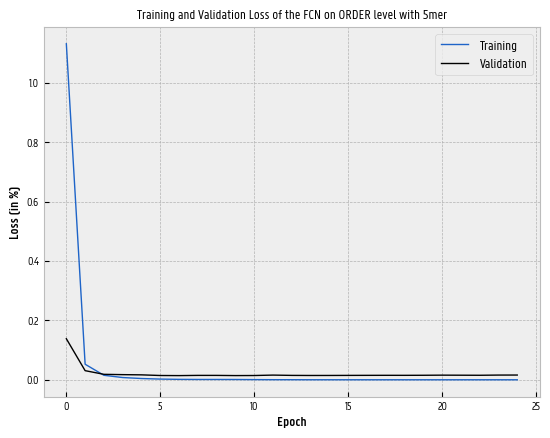

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

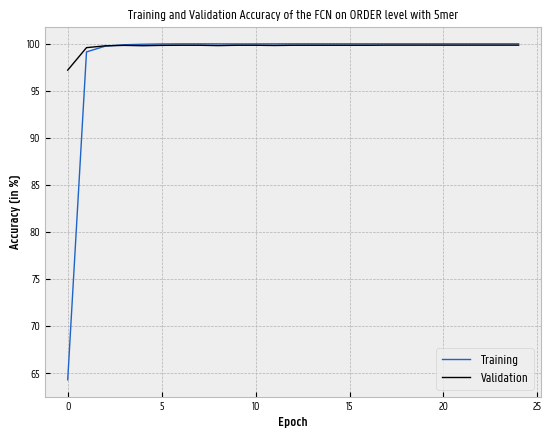

Training, validation and testing on ORDER level with 5mer is completed.


In [ ]:
FCNK('5mer', 'ORDER', 25)

Initiating training, validation and testing on FAMILY level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 1.6591, Training Accuracy: 51.42%
Epoch [1] Validation Loss: 0.3556, Validation Accuracy: 89.63%
Epoch [2] Training Loss: 0.1736, Training Accuracy: 96.07%
Epoch [2] Validation Loss: 0.0925, Validation Accuracy: 98.18%
Epoch [3] Training Loss: 0.0580, Training Accuracy: 98.97%
Epoch [3] Validation Loss: 0.0580, Validation Accuracy: 98.94%
Epoch [4] Training Loss: 0.0336, Training Accuracy: 99.48%
Epoch [4] Validation Loss: 0.0482, Validation Accuracy: 99.09%
Epoch [5] Training Loss: 0.0230, Training Accuracy: 99.57%
Epoch [5] Validation Loss: 0.0406, Validation Accuracy: 99.29%
Epoch [6] Training Loss: 0.0156, Training Accuracy: 99.70%
Epoch [6] Validation Loss: 0.0408, Validation Accuracy: 99.24%
Epoch [7] Training Loss: 0.0109, Training Ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

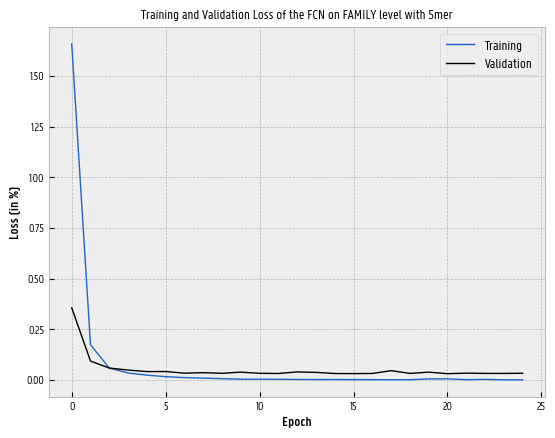

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

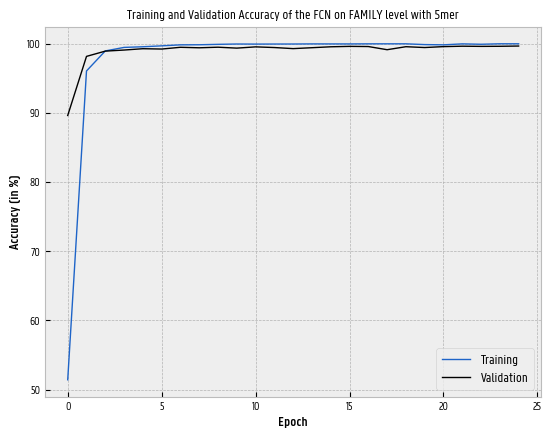

Training, validation and testing on FAMILY level with 5mer is completed.


In [ ]:
FCNK('5mer', 'FAMILY', 25)

Initiating training, validation and testing on GENUS level with 5mer.
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 2.0563, Training Accuracy: 43.74%
Epoch [1] Validation Loss: 0.6691, Validation Accuracy: 77.98%
Epoch [2] Training Loss: 0.3663, Training Accuracy: 88.88%
Epoch [2] Validation Loss: 0.2273, Validation Accuracy: 93.35%
Epoch [3] Training Loss: 0.1695, Training Accuracy: 94.62%
Epoch [3] Validation Loss: 0.1512, Validation Accuracy: 95.92%
Epoch [4] Training Loss: 0.1156, Training Accuracy: 96.57%
Epoch [4] Validation Loss: 0.1237, Validation Accuracy: 96.66%
Epoch [5] Training Loss: 0.0867, Training Accuracy: 97.50%
Epoch [5] Validation Loss: 0.1053, Validation Accuracy: 97.16%
Epoch [6] Training Loss: 0.0698, Training Accuracy: 98.00%
Epoch [6] Validation Loss: 0.1019, Validation Accuracy: 97.19%
Epoch [7] Training Loss: 0.0586, Training Acc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

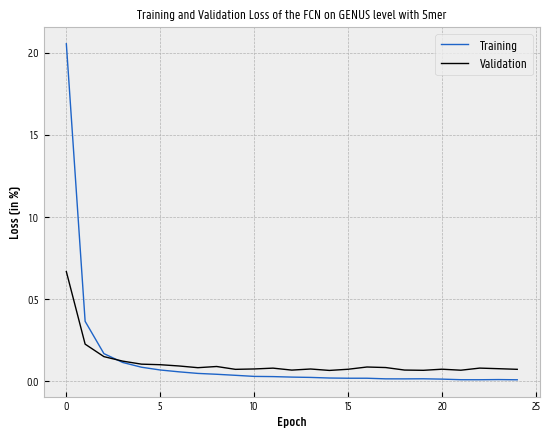

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

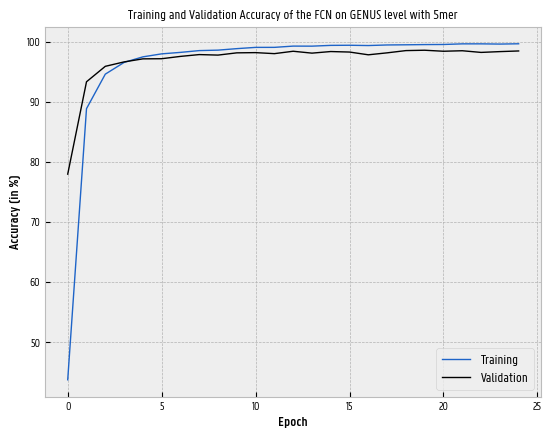

Training, validation and testing on GENUS level with 5mer is completed.


In [ ]:
FCNK('5mer', 'GENUS', 25)